Imports

In [1]:
#! /usr/bin/env python
# general
import os
import sys
import math
import copy
import time
import glob
import random
import io
import argparse

# torch
import torch
import torch.backends.cudnn as cudnn

# scypy
import scipy.misc
import scipy.ndimage as ndimage

# tensorflow
import tensorflow as tf

# math - display
from matplotlib import pyplot as plt
import numpy as np

# cv
import cv2
import imageio
from cv_bridge import CvBridge, CvBridgeError
from PIL import Image, ImageDraw, ImageFont
import open3d as o3d
from six import BytesIO
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

# ROS
import rospy
from sensor_msgs.msg import Image
from std_msgs.msg import Float64

# Robotics
import roboticstoolbox as rtb
from spatialmath import *
from spatialmath.base import *

# yolov5 
# from models.common import DetectMultiBackend
# from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
# from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                        #    increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
# from utils.torch_utils import select_device, time_sync
# from utils.plots import Annotator, colors, save_one_roi

# ggcnnv2 imports
from ggcnn.models import ggcnn2
from ggcnn.utils.dataset_processing import grasp, image, evaluation1
from ggcnn.utils.dataset_processing.grasp import GraspRectangle
from ggcnn.models.common import post_process_output
from ggcnn.utils.timeit import TimeIt

# agnostic segmentation
from agnostic_segmentation import agnostic_segmentation
# from agnostic_segmentation import compute_grasp

# object detection
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

2022-05-10 16:35:26.522791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-05-10 16:35:26.522825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO - 2022-05-10 16:35:29,235 - topics - topicmanager initialized


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Clases

In [5]:
class GetRosImage:
    def __init__(self):
        self.bridge = CvBridge()
        self.image_received = False
        # Connect image topic
        # rgb_topic = "/camera/color/image_raw"
        rgb_topic = "/cam/color/image_raw"
        self.image_sub = rospy.Subscriber(rgb_topic, Image, self.callback_rgb)
        # depth_topic = "/camera/depth/image_rect_raw"
        depth_topic = 'cam/depth/image_raw'
        self.depth_sub = rospy.Subscriber(depth_topic, Image, self.callback_depth)
        # Allow up to one second to connection
        rospy.sleep(0.5)

    def callback_rgb(self, data):
        # Convert image to OpenCV format
        try:
            rgb_image = self.bridge.imgmsg_to_cv2(data, "bgr8")
        except CvBridgeError as e:
            print(e)
        self.image_received = True
        self.rgb_image = rgb_image
    
    def callback_depth(self, data):
        try:
            depth_image = self.bridge.imgmsg_to_cv2(data, desired_encoding="32FC1")
        except CvBridgeError as e:
            print(e)
        self.depth_image = depth_image

    def take_picture(self, save=True):
        if self.image_received:
            if save == True:
                cv2.imwrite('rgb.jpg', self.rgb_image)
                cv2.imwrite('depth.tiff',cv2.normalize(self.depth_image,self.depth_image,0,255,cv2.NORM_MINMAX))
                cv2.imwrite('depth.jpg',cv2.normalize(self.depth_image,self.depth_image,0,255,cv2.NORM_MINMAX))
            return (self.rgb_image, self.depth_image)
        else:
            return False

Funciones

In [19]:
def grasp_img_preprocessing():
    with TimeIt('1'):
       depth_crop = cv2.copyMakeBorder(depth_crop, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
       depth_nan_mask = np.isnan(depth_crop).astype(np.uint8)
       depth_crop[0,0]
       print(depth_crop.shape)
    with TimeIt('2'):
       depth_crop[depth_nan_mask==1] = 0
    # Value normalization [-1 1]
    with TimeIt('3'):
       depth_scale = np.abs(depth_crop).max()
       depth_crop = depth_crop.astype(np.float32) / depth_scale 
    # Remove scratches
    # with TimeIt('Inpainting'):
       # depth_crop = cv2.inpaint(depth_crop, depth_nan_mask, 1, cv2.INPAINT_NS)
    # Remove border and rescalate the image
    depth_crop = depth_crop[1:-1, 1:-1] 
    depth_crop = depth_crop * depth_scale
    depth = depth_crop
    depth = np.clip((depth - depth.mean()), -1, 1)
    depthn = depth.copy()
    # Convert depth_img to a torch tensor 
    depthT = torch.from_numpy(depth.reshape(1, 1, depth.shape[0], depth.shape[1]).astype(np.float32)).to(device2)


def draw_angled_rec(x0, y0, width, height, angle, color, img):
    _angle = angle * math.pi / 180.0
    b = math.cos(_angle) * 0.5
    a = math.sin(_angle) * 0.5
    pt0 = (int(x0 - a * height - b * width),
           int(y0 + b * height - a * width))
    pt1 = (int(x0 + a * height - b * width),
           int(y0 - b * height - a * width))
    pt2 = (int(2 * x0 - pt0[0]), int(2 * y0 - pt0[1]))
    pt3 = (int(2 * x0 - pt1[0]), int(2 * y0 - pt1[1]))

    cv2.line(img, pt0, pt1, (), 1)
    cv2.line(img, pt1, pt2, color, 1)
    cv2.line(img, pt2, pt3, color, 1)
    cv2.line(img, pt3, pt0, color, 1)
    plt.imshow(img)
    plt.show()



File load

In [6]:
from_ros = True
if from_ros == True:
    rospy.init_node('take_photo', anonymous=False)
    camera = GetRosImage()
    camera_result = camera.take_picture()
    if isinstance(camera_result,tuple):
        rgb_img, depth_img = camera_result
        print("Saved image")
    else:
        print("No images received")

Saved image


Retinanet

Agnostic

In [26]:
from_file = True
img_path = 'rgb.jpg'
if from_file == True:
    rgb_img = cv2.imread(img_path)

In [7]:
###################################################################################################
# Agnostic segmentation
###################################################################################################
model_path = '/home/felipe/code/APC/grasping/models/FAT_trained_Ml2R_bin_fine_tuned.pth'
# Predicciones
predictions = agnostic_segmentation.segment_image(rgb_img, model_path, 0.2)
# Bounding boxes -> List of np arrays with the box [x0 y0 x1 y1]
boxes = predictions['instances'].pred_boxes.tensor
boxes_np = boxes.cpu().detach().numpy().astype(int)
# Masks -> List of np arrays binary matriz [0's backgorud 1's object]
masks = predictions['instances'].pred_masks
# To visulize the detected objects
seg_img = agnostic_segmentation.draw_segmented_image(rgb_img, predictions)
print(boxes_np)

[[283 255 332 304]
 [217 164 290 261]
 [ 19 282 148 477]
 [  0 164 163 298]
 [130   0 299 118]
 [336 183 380 215]
 [ 35 399 137 479]
 [  3  42 166 291]]


In [ ]:
# TODO usar mascara para rellenar
# TODO revisar orden de detección de objetos
# TODO print todas las regiones detectadas con titulo y orden

In [41]:
%matplotlib qt
num_detects = boxes_np.shape[0]
print(num_detects)
for i in range(0,num_detects):
    roi = boxes_np[i]
    plt.subplot(num_detects,3,3*i+1)
    plt.imshow(seg_img[:,:,::-1])
    plt.gca().set_title('Global')
    plt.axis('off')
    plt.subplot(num_detects,3,3*i+2)
    plt.imshow(rgb_img[roi[1]:roi[3], roi[0]:roi[2]][:,:,::-1])
    plt.gca().set_title('Segmented no.'+str(i+1))
    plt.axis('off')
    plt.subplot(num_detects,3,3*i+3)
    plt.imshow(masks[i].cpu().detach().numpy()[boxes_np[i][1]:boxes_np[i][3],
    boxes_np[i][0]:boxes_np[i][2]], cmap='gray')
    plt.gca().set_title('Mask no. '+str(i+1))
    plt.axis('off')
plt.show()


8


In [93]:
%matplotlib qt
# Object selection
box_index = 5
# Zoom % aroun the bounding box
zoom_h = 0.1
zoom_w = 0.75*zoom_h
# ROI selection
roi = (boxes_np[box_index]*np.array([1-zoom_w, 1-zoom_h, 1+zoom_w, 1+zoom_h])).astype(int)
print(roi)
# Plotting
plt.subplot(1,3,1)
plt.imshow(seg_img[:,:,::-1])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(rgb_img[roi[1]:roi[3], roi[0]:roi[2]][:,:,::-1])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(masks[box_index].cpu().detach().numpy()[boxes_np[box_index][1]:boxes_np[box_index][3],
boxes_np[box_index][0]:boxes_np[box_index][2]], cmap='gray')
plt.axis('off')
plt.show()

[310 164 408 236]


GGCNN2

In [94]:
print(from_file)
if from_file == True:
    # RGB img load-> El metodo ya esta definido en utils.dataset_processing import image
    # rgb_img = image.Image.from_file('/home/felipe/code/APC/ggcnn/datasets/cornell/03/pcd0313r.png')

    # Depth igm load -> El metodo ya esta definido en utils.dataset_processing import image DepthImage
    # From .tiff image
    # depth_img = image.DepthImage.from_tiff('/home/felipe/code/APC/ggcnn/datasets/cornell/03/pcd0313d.tiff')
    # From .pcd point cloud
    depth_img = image.DepthImage.from_tiff('depth.tiff')
    # depth_img_pcd = image.DepthImage.from_pcd('/home/felipe/code/APC/ggcnn/datasets/cornell/03/pcd0313.txt',depth_img.__getattr__('shape'))

    # Get depth image attributes
    imh, imw = depth_img.__getattr__('shape')
    print(imh, imw)

True
480 640


In [95]:
###################################################################################################
# GGCNN
###################################################################################################
# Device selecion (device 2 - not interfering with AS)
device2 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
out_size = 300
y_off = 0
x_off = 0
# GGCNN Model
MODEL_FILE = 'ggcnn/ggcnn2_093'
model2 = torch.load(MODEL_FILE, map_location=device2)

# depth_crop tiene que ser un array 
depth_crop = np.asarray(depth_img)
depth_crop2 = np.asarray(depth_img)
# The ROI region is crop to the depth image
depth_crop = depth_crop[roi[1]:roi[3], roi[0]:roi[2]]
%matplotlib qt
plt.imshow(depth_img)
plt.axis('off')
plt.show()

In [96]:
mask = masks[box_index].cpu().detach().numpy()
d = depth_crop2[240,320]

for j in range(depth_crop2.shape[0]):
    for i in range(depth_crop2.shape[1]):
        if not mask[j][i]:
            depth_crop2[j][i] = d


depth_crop = depth_crop2[roi[1]:roi[3],roi[0]:roi[2]]
%matplotlib qt
plt.imshow(depth_crop)
plt.axis('off')
plt.show()


In [98]:
# Depth image preprocessing
# Add 1 pix border and check nan pixels
with TimeIt('1'):
    depth_crop = cv2.copyMakeBorder(depth_crop, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    depth_nan_mask = np.isnan(depth_crop).astype(np.uint8)
depth_crop[0,0]
print(depth_crop.shape)
with TimeIt('2'):
    depth_crop[depth_nan_mask==1] = 0
# Value normalization [-1 1]
with TimeIt('3'):
    depth_scale = np.abs(depth_crop).max()
    depth_crop = depth_crop.astype(np.float32) / depth_scale 
# Remove scratches
# with TimeIt('Inpainting'):
    # depth_crop = cv2.inpaint(depth_crop, depth_nan_mask, 1, cv2.INPAINT_NS)
# Remove border and rescalate the image
depth_crop = depth_crop[1:-1, 1:-1] 
depth_crop = depth_crop * depth_scale
depth = depth_crop
depth = np.clip((depth - depth.mean()), -1, 1)
depthn = depth.copy()
# Convert depth_img to a torch tensor 
depthT = torch.from_numpy(depth.reshape(1, 1, depth.shape[0], depth.shape[1]).astype(np.float32)).to(device2)

1: 0.3ms
(74, 100)
2: 0.0ms
3: 0.0ms


/tmp/ipykernel_225348/710706916.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  points_out = ndimage.filters.gaussian_filter(points_out, filters[0])  # 3.0
/tmp/ipykernel_225348/710706916.py:17: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  ang_out = ndimage.filters.gaussian_filter(ang_out, filters[1])
/tmp/ipykernel_225348/710706916.py:18: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  width_out = ndimage.filters.gaussian_filter(width_out, filters[2])


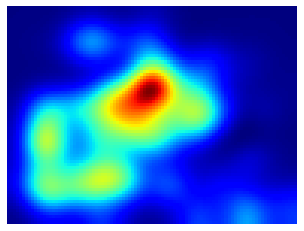

In [99]:
# Grasp Predictions
with torch.no_grad():
    pred_out = model2(depthT)
# Convert TorchTensor to NP array for manipulation and  filtering
# Quality
points_out = pred_out[0].cpu().numpy().squeeze() 
# Yaw angle
cos_out = pred_out[1].cpu().numpy().squeeze()
sin_out = pred_out[2].cpu().numpy().squeeze()
ang_out = np.arctan2(sin_out, cos_out) / 2.0 
# Gripper apperture
width_out = pred_out[3].cpu().numpy().squeeze() * 70.0  # Scaled 0-150:0-1

# Filters to smoothing
filters=(5.0, 4.0, 2.0)
points_out = ndimage.filters.gaussian_filter(points_out, filters[0])  # 3.0
ang_out = ndimage.filters.gaussian_filter(ang_out, filters[1])
width_out = ndimage.filters.gaussian_filter(width_out, filters[2])
points_out = np.clip(points_out, 0.0, 1.0-1e-3)
# Plotting
%matplotlib inline
plt.imshow(points_out,cmap='jet')
plt.axis('off')
plt.show()

In [100]:
# Grasp Detection
grasps = grasp.detect_grasps(points_out, ang_out, 0.3, width_img=width_out, no_grasps=10)
grasps_info = evaluation1.grasp_info(width_out, points_out, ang_out, grasps)
for g in grasps_info:
    # Pixels accorging to the segmented region, not the complete image
    print(g)

len 1
localn [[28. 47.]]
{'q': 0.3192616, 'pix': [28, 47], 'ang': -3.3355625816502776, 'width': 12.193038}


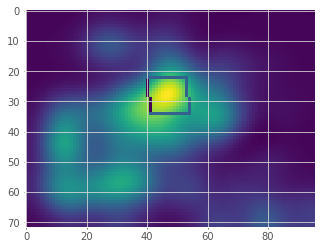

In [101]:
# Grasps plotting
test = points_out.copy()
for g in grasps_info:
    draw_angled_rec(g['pix'][1],g['pix'][0],g['width'],g['width'],g['ang'],(0.1,0.1,0),test)

In [102]:
# Grasps pixels on the original img
g_num = 0
pix_x = roi[0]+grasps_info[g_num]['pix'][1]
pix_y = roi[1]+grasps_info[g_num]['pix'][0]
g_angle = -grasps_info[g_num]['ang']
print('x',' ','y')
print(pix_x, pix_y)

x   y
357 192


Perception analysis

In [103]:
# Shorten print matrices
np.set_printoptions(suppress=True)

# Camera matrix  calibrations
# Real Kinect
# A = np.array([[507.441511, 0, 307.533215],[0, 509.477448, 270.604765],[0, 0, 1]])
# Default Kinect Package
# A = np.array([[525, 0, 319.5],[0, 525, 239.5],[0, 0, 1]])
# Gazebo calib 
A = np.array([[554.2547, 0, 320.5],[0, 554.2547, 240.5],[0, 0, 1]]) 

# MTH for the camera (only applies on my  layout)
Tcam = transl(0.49,0.25,0).dot(trotz(np.pi/2)).dot(trotx(np.pi))

# Conversion to distance (z = 1m)
# TODO use the depth image to get distance to the table
x_cam = (pix_x-A[0,2])/A[0,0]
y_cam = (pix_y-A[1,2])/A[1,1]
Pcam = np.array([x_cam, y_cam, 1, 1])
Pori = Tcam.dot(Pcam)
print("x(m):", Pori[0], "y(m):", Pori[1], "angle(deg):", -g_angle)


x(m): 0.40249510378531755 y(m): 0.31585420024403943 angle(deg): -3.3355625816502776


In [150]:
pub = rospy.Publisher('/gripper_controller/command', Float64, queue_size=10)
pub.publish(1)
    

In [65]:
topics = rospy.get_published_topics()

In [74]:
for topic in topics:
    if '/gripper_controller/command' in topic:
        print('ok')

ok
